In [2]:
%pylab inline
%run ../../figures/params.py

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import pandas as pd
import os
import numpy as np
import sklearn.cross_validation as xval
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.ensemble import RandomForestRegressor
import scipy.stats

MAXLEN = 20

features = ['uninterrupted_length','p2', 'p4']

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Load parameters
params = {}
with open("params.sh", "r") as f:
    for line in f:
        if "=" not in line: continue
        key, val = line.strip().split("=")
        params[key] = val

In [29]:
params["BASEDIR"] = "/Users/gymrek/workspace/mutea-autosomal/analyses/data/"
params["PREDFILE"] = os.path.join("/Users/gymrek/workspace/mutea-autosomal/analyses/data/constraint/autosomal_perlocus_estimates_smm.bed")

In [11]:
ml_datafile = os.path.join(params["BASEDIR"], "constraint","autosomal_perlocus_train_intergenic.bed.gz")
ml_dataset = pd.read_csv(ml_datafile, sep="\t").drop_duplicates()
smm_datafile = os.path.join(params["BASEDIR"], "autosomal_estimates", "perlocus", "autosomal_estimates_smm_filtered.bed.gz")
smm_dataset = pd.read_csv(smm_datafile, sep="\t", 
                          names=["chrom","start","end","ml_mu","ml_beta","ml_p","ml_mu_stderr","numsamples","strfilter"]).drop_duplicates()
columns = ["chrom","start","end","motif","length","uninterrupted_length","reptiming","score","GC","entropy","featurefilter"]
dataset = pd.merge(smm_dataset, ml_dataset[columns], on=["chrom","start","end"])

In [16]:
# Set new features
dataset['period'] = dataset['motif'].str.len()
dataset["pbyl"] = dataset.apply(lambda x: x["uninterrupted_length"]*1.0/x["period"], 1)
dataset['p2'] = (dataset["period"]==2).apply(int)
dataset['p4'] = (dataset["period"]==4).apply(int)

# Restrict to di, tri, tetra, longer
dataset = dataset[dataset["period"].apply(lambda x: x in [2,3,4])]
dataset = dataset[~dataset["featurefilter"]]
dataset = dataset[dataset["length"]>=MAXLEN]

In [26]:
def CenterData(data):
    df = pd.DataFrame({"data": data, "ind": range(data.shape[0])})
    df = df.sort("data")
    vals = np.random.normal(size=data.shape[0])
    vals = sorted(vals)
    df["norm"] = vals
    df = df.sort("ind")
    return df["norm"]

def SetFilterModel1(df, colname="filter"):
    df[colname] = False
    df.ix[np.isinf(df["ml_mu_stderr"]), colname] = True
    
def SetFilterModel2(df, colname="filter"):
    df[colname] = False
    #df.ix[(df["ml_mu_stderr_adj"]<0), colname] = True

0.491174336069
(nan, 1.0) 42197
(0.70243384316213764, 0.0) 24688


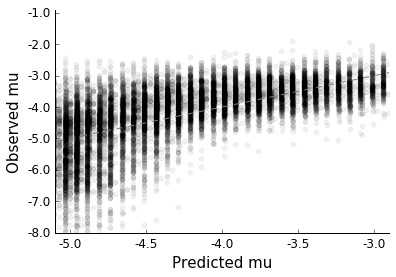

In [27]:
##################
# Linear Regression - Model 1
##################

filtercolor = "gray"
keepcolor = "black"

# Set filter field
SetFilterModel1(dataset, colname="filter1_smm")

# Center data (not length and period)
#for f in ["gc","entropy","recomb","reptiming"]:
#    dataset[f] = CenterData(dataset[f])

# Split data to train and test
base_X = dataset[features] #pd.get_dummies(dataset[features], prefix="motif")
base_y = dataset['ml_mu']
base_filter = dataset["filter1"]
base_weights = dataset["ml_mu_stderr"].apply(lambda x: 1.0/(x**2))
train_X, test_X, \
    train_y, test_y, \
    train_filter, test_filter, \
    train_weights, test_weights = xval.train_test_split(base_X, base_y, base_filter, base_weights, test_size=0.25)
y_colors = test_filter.apply(lambda x: [keepcolor, filtercolor][int(x)])

# Filter training data
train_X = train_X[~train_filter]
train_y = train_y[~train_filter]
train_weights = train_weights[~train_filter]

# Build linear regression model
train_X_sm = sm.add_constant(train_X)
model1 = sm.OLS(train_y, train_X_sm)
smols1 = model1.fit()
pred_y = smols1.predict(sm.add_constant(test_X))

# Plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(pred_y[y_colors.values==filtercolor], test_y[y_colors.values==filtercolor], alpha=0.01, color=filtercolor, s=10)
ax.scatter(pred_y[y_colors.values==keepcolor], test_y[y_colors.values==keepcolor], alpha=0.05, color=keepcolor)
plt.plot([-7, -2],[-7,-2], color="gray", linestyle="dashed")
ax.set_xlim(left=-5.1, right=-2.9)
ax.set_ylim(bottom=-8, top=-0.9)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Predicted mu", size=15)
ax.set_ylabel("Observed mu", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
fig.savefig(os.path.join("../../figures/", PLOTDIR, "Figure3_modeleval.png"))

print smols1.rsquared_adj
print pearsonr(pred_y[~test_filter.values], test_y[~test_filter.values]), len(pred_y[~test_filter.values])

In [39]:
##################
# Predict
##################

# Load data
ml_datafile = os.path.join(params["BASEDIR"], "constraint","autosomal_perlocus_observed.bed.gz")
ml_dataset = pd.read_csv(ml_datafile, sep="\t").drop_duplicates()
smm_datafile = os.path.join(params["BASEDIR"], "autosomal_estimates", "perlocus", "autosomal_estimates_smm_filtered.bed.gz")
smm_dataset = pd.read_csv(smm_datafile, sep="\t", 
                          names=["chrom","start","end","ml_mu","ml_beta","ml_p","ml_mu_stderr","numsamples","strfilter"]).drop_duplicates()
columns = ["chrom","start","end","motif","length","uninterrupted_length","reptiming","score","GC","entropy","featurefilter"]
dataset = pd.merge(smm_dataset, ml_dataset[columns], on=["chrom","start","end"])

# Load extra features
dataset["period"] = dataset["motif"].apply(len)
dataset["pbyl"] = dataset.apply(lambda x: x["uninterrupted_length"]*1.0/x["period"], 1)
dataset['p2'] = (dataset["period"]==2).apply(int)
dataset['p4'] = (dataset["period"]==4).apply(int)

# Filter
dataset = dataset[dataset["period"].apply(lambda x: x in [2,3,4])]
dataset = dataset[dataset["length"]>=MAXLEN]
SetFilterModel1(dataset, colname="filter1_smm")

# Predict and save
dataset['pred_mu_1_smm'] = smols1.predict(sm.add_constant(dataset[features]))
dataset['pred_mu_se_1_smm'] = wls_prediction_std(smols1, sm.add_constant(dataset[features]))[0]

# Analyze zscores
def GetZscore(x, prefix=""):
    num = x["ml_mu"] - x["pred_mu%s"%prefix]
    se = x["ml_mu_stderr"]
    if se < 0: se = 0
    denom = np.sqrt(se**2/2 + x["pred_mu_se%s"%prefix]**2/2)
    return num/denom

dataset["zscore_1_smm"] = dataset.apply(lambda x: GetZscore(x, "_1_smm"), 1)
dataset["diff_1_smm"] = dataset["ml_mu"] - dataset["pred_mu_1_smm"]

# Rename ML columns
dataset["smm_mu"] = dataset["ml_mu"]
dataset["smm_mu_stderr"] = dataset["ml_mu_stderr"]

# Set zscore to NA when it is -inf
dataset.ix[np.isinf(dataset["ml_mu"]), "zscore_1_smm"] = np.nan

header = ['chrom','start','end','smm_mu','smm_mu_stderr','motif', "uninterrupted_length", \
          'pred_mu_1_smm','pred_mu_se_1_smm', 'filter1_smm',\
         'zscore_1_smm','diff_1_smm']
dataset[header].to_csv(params["PREDFILE"], columns=header, index=False)

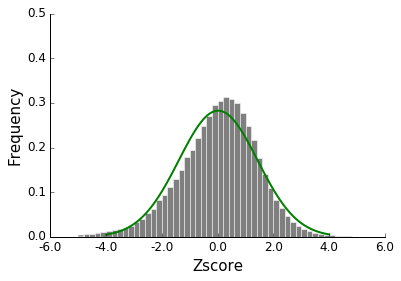

In [47]:
for i in [1]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    bins = np.arange(-5, 5, 0.2)
    #ax.hist(dataset[dataset["filter%s_smm"%i]]["zscore_%s_smm"%i], bins=bins, edgecolor="white", color="cyan", normed=True, alpha=0.5);
    ax.hist(dataset[~dataset["filter%s_smm"%i]]["zscore_%s_smm"%i], bins=bins, edgecolor="white", color="black", normed=True, alpha=0.5);
    #ax.hist(dataset["zscore_%s_smm"%i], bins=bins, edgecolor="white", color="red", normed=True, alpha=0.5);
    ax.set_ylim(bottom=0, top=0.5)

    # Fit normal - unfiltered
    mu = np.mean(dataset[~dataset["filter%s_smm"%i]]["zscore_%s_smm"%i])
    std = np.sqrt(np.var(dataset[~dataset["filter%s_smm"%i]]["zscore_%s_smm"%i]))
    xvals = np.linspace(-4, 4, 100)
    p = scipy.stats.norm.pdf(xvals, mu, std)
    ax.plot(xvals, p, linewidth=2, color="green")

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel("Zscore", size=15)
    ax.set_ylabel("Frequency", size=15)
    ax.set_xticklabels(ax.get_xticks(), size=12)
    ax.set_yticklabels(ax.get_yticks(), size=12);

In [69]:
# Compare SMM based constraint score to OU based constraint scores
ml_datafile = os.path.join("/Users/gymrek/workspace/mutea-autosomal/analyses/data/constraint/autosomal_perlocus_estimates.bed")
ml_dataset = pd.read_csv(ml_datafile)
compare = pd.merge(ml_dataset[["chrom","start","end","zscore_1","zscore_2","ml_mu","filter1"]], 
                   dataset[["chrom","start","end","zscore_1_smm","smm_mu","filter1_smm"]])

(0.87564476322641782, 0.0)
(0.55609056676769908, 0.0)
(0.64553818355428172, 0.0)


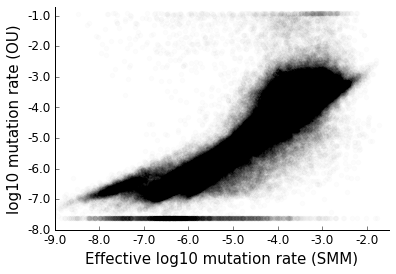

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(compare["smm_mu"], compare["ml_mu"], color="black", alpha=0.01)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(left=-9, right=-1.5)
ax.set_ylim(bottom=-8, top=-0.7)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.set_xlabel("Effective log10 mutation rate (SMM)", size=15)
ax.set_ylabel("log10 mutation rate (OU)", size=15)
fig.savefig(os.path.join("../../figures/", PLOTDIR, "SuppFig_OUSMMauto.png"))

print(scipy.stats.pearsonr(compare[~compare["filter1_smm"]]["smm_mu"], compare[~compare["filter1_smm"]]["ml_mu"]))

print(scipy.stats.pearsonr(compare[(~compare["filter1_smm"]&~compare["filter1"])]["zscore_1"],
                           compare[(~compare["filter1_smm"]&~compare["filter1"])]["zscore_1_smm"]))

print(scipy.stats.pearsonr(compare[~compare["filter1_smm"]]["zscore_2"], compare[~compare["filter1_smm"]]["zscore_1_smm"]))